In [15]:
# Import the required libraries
import os
os.environ['USE_PYGEOS'] = '0'
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show


In [5]:
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box

In [2]:
dem_path = "/home/jovyan/Neethusree/ASTGTMV003_N25E093_dem.tif"

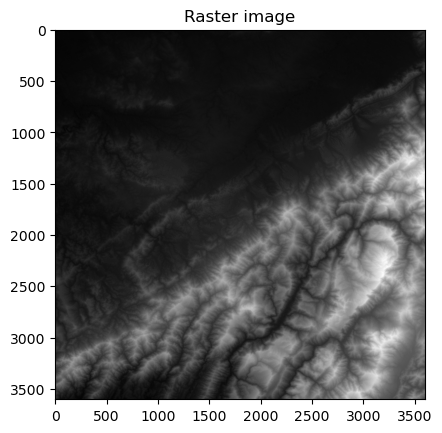

EPSG:4326


In [4]:
# Open raster file
with rasterio.open(dem_path) as dataset:
   
    band1 = dataset.read(1)
    # Plot the raster band using matplotlib
    plt.imshow(band1, cmap='gray')
    plt.title('Raster image')
    plt.show()
    print(dataset.crs)

In [6]:
# CLip the boundary
min_lon, max_lon = 93 + 5.5/60, 93 + 8.5/60   # 93°5'30"E to 93°8'30"E
min_lat, max_lat = 25 + 11/60, 25 + 13/60     # 25°11'0"N to 25°13'0"N

bbox = box(min_lon, min_lat, max_lon, max_lat)
geo = gpd.GeoDataFrame({'geometry': [bbox]}, crs="EPSG:4326")


with rasterio.open(dem_path) as src:
    coords = [geo.geometry[0].__geo_interface__]
    out_image, out_transform = mask(src, shapes=coords, crop=True)
    out_meta = src.meta.copy()

# Save clipped DEM 
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})
with rasterio.open("clipped_dem.tif", "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Clipped DEM saved as clipped_dem.tif")

✅ Clipped DEM saved as clipped_dem.tif


In [7]:

from rasterio.warp import calculate_default_transform, reproject, Resampling

# Correct destination CRS for Assam, India (WGS 84 / UTM Zone 46N)
dst_crs = 'EPSG:32646' 
input_raster = 'clipped_dem.tif'
output_raster = 'dem_projected.tif' # The new file we will create

with rasterio.open(input_raster) as src:
    # Check if the source CRS is indeed what we expect (EPSG:4326)
    print(f"Original file CRS: {src.crs}")

    # Calculate transformation parameters for reprojection
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Set up metadata for the new file
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Write the new, reprojected raster to a file
    with rasterio.open(output_raster, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.cubic)

print(f"\nReprojection complete. New file '{output_raster}' created with CRS {dst_crs}.")

Original file CRS: EPSG:4326

Reprojection complete. New file 'dem_projected.tif' created with CRS EPSG:32646.


In [ ]:

from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define the target Coordinate Reference System (CRS) in meters.
# Replace 'EPSG:32633' with the appropriate UTM zone for your area.
# For Berlin, Germany, UTM Zone 33N is a good choice.
dst_crs = 'EPSG:32633' 
input_raster = 'clipped_dem.tif'
output_raster = 'dem_projected.tif' # The new file we will create

with rasterio.open(input_raster) as src:
    # Calculate the transformation parameters for reprojection
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Set up the metadata for the output file
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Write the new, reprojected raster to a file
    with rasterio.open(output_raster, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.cubic)

print(f"Reprojection complete. New file saved as '{output_raster}'")

Slope shape: (129, 176)
Slope min: 0.0, max: 87.44900161746634
Number of NaNs: 0


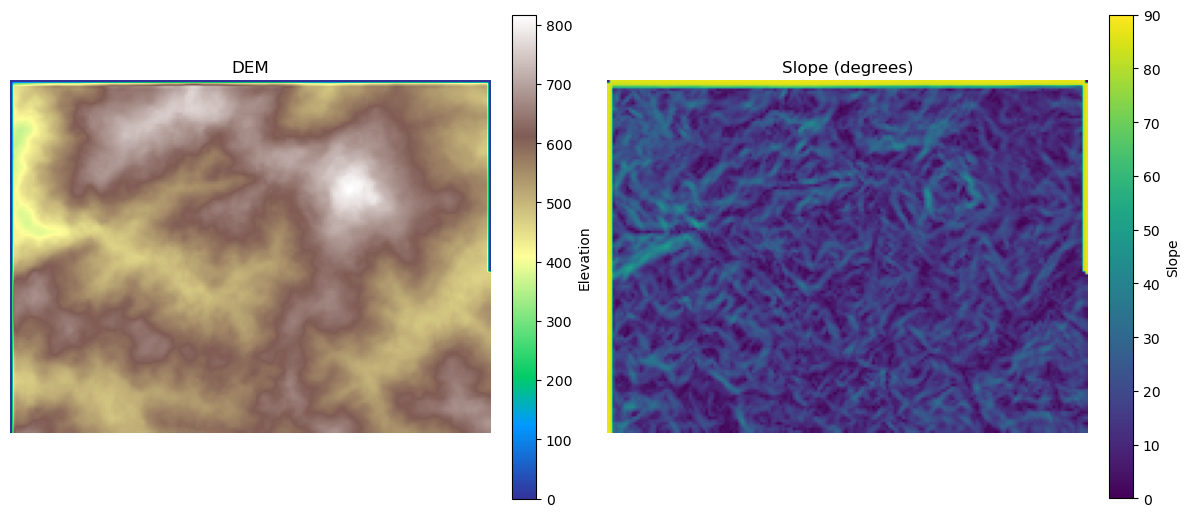

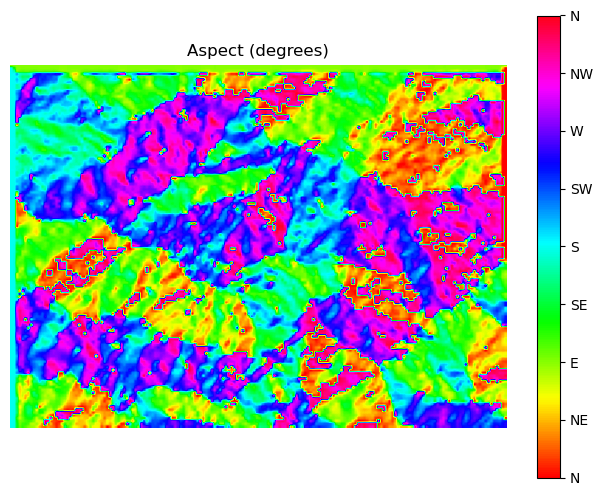

In [8]:

import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open("dem_projected.tif") as src:
    elevation = src.read(1)
    xres, yres = src.res

dy, dx = np.gradient(elevation, yres, xres)
slope = np.degrees(np.arctan(np.hypot(dx, dy)))
aspect = np.degrees(np.arctan2(-dx, dy))
aspect = np.mod(90 - aspect, 360)

# Create the figure and the array of axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# --- Plot 1: DEM ---
# Use ax[0] to access the first subplot
dem_img = ax[0].imshow(elevation, cmap='terrain')
ax[0].set_title('DEM') # CORRECTED
ax[0].axis('off')      # CORRECTED
plt.colorbar(dem_img, ax=ax[0], fraction=0.046, pad=0.04, label='Elevation') # CORRECTED (best practice)

# --- Plot 2: Slope ---
# Use ax[1] to access the second subplot (NOT ax[10])
slope_img = ax[1].imshow(slope, cmap='viridis', vmin=0, vmax=90) # CORRECTED
ax[1].set_title('Slope (degrees)') # CORRECTED
ax[1].axis('off')                  # CORRECTED
plt.colorbar(slope_img, ax=ax[1], fraction=0.046, pad=0.04, label='Slope') # CORRECTED

plt.tight_layout()
plt.show()

# Aspect plot (this part was already correct)
plt.figure(figsize=(8, 6))
aspect_img = plt.imshow(aspect, cmap=plt.cm.hsv, vmin=0, vmax=360)
cbar = plt.colorbar(aspect_img, ticks=np.arange(0, 361, 45))
cbar.ax.set_yticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
plt.title('Aspect (degrees)')
plt.axis('off')
plt.show()



In [10]:

import numpy as np

print(f"Slope shape: {slope.shape}")
print(f"Slope min: {np.nanmin(slope)}, max: {np.nanmax(slope)}")
print(f"Number of NaNs: {np.sum(np.isnan(slope))}")


Slope shape: (129, 176)
Slope min: 0.0, max: 87.44900161746634
Number of NaNs: 0


In [12]:
!pip install pysheds matplotlib

In [16]:
import rasterio

with rasterio.open("clipped_dem.tif") as src:
    print("Current NoData value:", src.nodata)


Current NoData value: None


/opt/conda/lib/python3.11/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


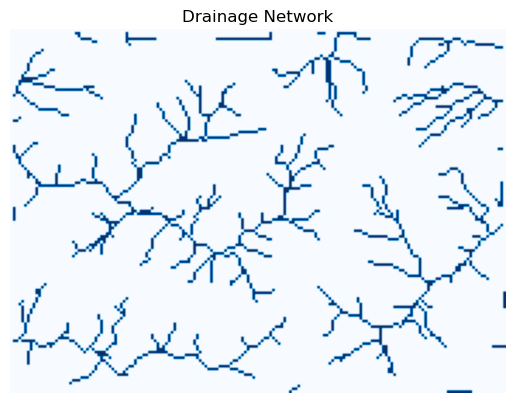

In [17]:
# Drainage
from pysheds.grid import Grid

grid = Grid.from_raster('dem_projected.tif', data_name='dem', nodata=-9999)
dem = grid.read_raster('dem_projected.tif')

# Fill sinks
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)

# Flow direction
fdir = grid.flowdir(inflated_dem)

# Flow accumulation
acc = grid.accumulation(fdir)

# Extract streams
streams = acc > 50

# plot
plt.imshow(streams, cmap='Blues')
plt.title('Drainage Network')
plt.axis('off')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

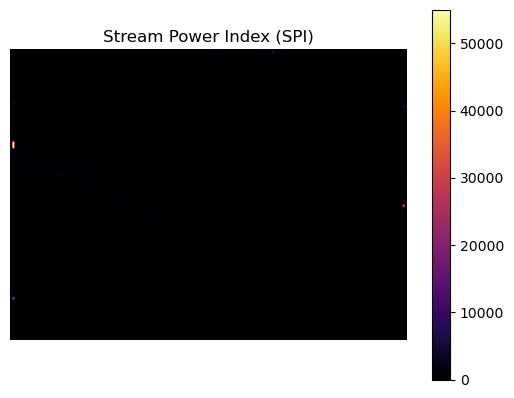

In [18]:
# Stream power index
slope_rad = np.radians(slope)

spi = acc*np.tan(slope_rad)

# plot
plt.imshow(spi, cmap='inferno')
plt.title('Stream Power Index (SPI)')
plt.colorbar()
plt.axis('off')
plt.show